### Setup

In [1]:
# ===================== Imports =====================
import os
import random
import time
import warnings
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, models, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

from sklearn.model_selection import train_test_split

# ===================== Configuration =====================
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set seeds for reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ===================== TensorFlow Info =====================
print("TensorFlow version:", tf.__version__)
gpu_devices = tf.config.list_physical_devices('GPU')
print("GPU available:", gpu_devices if gpu_devices else "No GPU detected")


TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Data Preparation

In [ ]:
import os
import shutil
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ===================== Config =====================
DATA_URL = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
DATA_ZIP = "tiny-imagenet-200.zip"
EXTRACT_DIR = "/content/tiny-imagenet"
SUBSET_DIR = "/content/imagenet_20"
TARGET_SIZE = (64, 64)
BATCH_SIZE_TRAIN = 64
BATCH_SIZE_TEST = 32
NUM_CLASSES = 20
SEED = 42

# ===================== Download & Extract =====================
def download_and_extract_tiny_imagenet(url=DATA_URL, zip_path=DATA_ZIP, extract_dir=EXTRACT_DIR):
    if not os.path.exists(extract_dir):
        os.system(f"wget -q {url}")
        os.system(f"unzip -q {zip_path} -d {extract_dir}")
        print(f"Extracted Tiny-ImageNet to {extract_dir}")
    else:
        print(f"{extract_dir} already exists. Skipping download.")

download_and_extract_tiny_imagenet()

# ===================== Create 20-Class Subset =====================
def create_subset(selected_classes=NUM_CLASSES, train_dir=os.path.join(EXTRACT_DIR, "tiny-imagenet-200/train"),
                val_dir=os.path.join(EXTRACT_DIR, "tiny-imagenet-200/val"), subset_dir=SUBSET_DIR):

    # Create train subset
    all_classes = sorted(os.listdir(train_dir))
    selected_classes = all_classes[:selected_classes]
    subset_train_dir = os.path.join(subset_dir, "train")
    os.makedirs(subset_train_dir, exist_ok=True)

    for cls in selected_classes:
        shutil.copytree(os.path.join(train_dir, cls), os.path.join(subset_train_dir, cls), dirs_exist_ok=True)

    # Create validation subset
    val_annotations = pd.read_csv(
        os.path.join(val_dir, "val_annotations.txt"),
        sep='\t', names=['file', 'class', 'x1', 'y1', 'x2', 'y2']
    )
    subset_val_dir = os.path.join(subset_dir, "val")
    os.makedirs(subset_val_dir, exist_ok=True)

    for cls in selected_classes:
        os.makedirs(os.path.join(subset_val_dir, cls), exist_ok=True)

    val_images_dir = os.path.join(val_dir, "images")
    for _, row in val_annotations.iterrows():
        if row['class'] in selected_classes:
            shutil.copy(
                os.path.join(val_images_dir, row['file']),
                os.path.join(subset_val_dir, row['class'], row['file'])
            )
    print(f"Created 20-class subset at {subset_dir}")

create_subset()

# ===================== Data Generators =====================
def create_data_generators(subset_dir=SUBSET_DIR, target_size=TARGET_SIZE, batch_size_train=BATCH_SIZE_TRAIN,
                           batch_size_test=BATCH_SIZE_TEST, seed=SEED):

    # Training & validation generator with augmentation
    train_datagen = ImageDataGenerator(
        preprocessing_function=resnet_preprocess,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        validation_split=0.1
    )

    train_generator = train_datagen.flow_from_directory(
        os.path.join(subset_dir, "train"),
        target_size=target_size,
        batch_size=batch_size_train,
        class_mode='categorical',
        subset='training',
        shuffle=True,
        seed=seed
    )

    val_generator = train_datagen.flow_from_directory(
        os.path.join(subset_dir, "train"),
        target_size=target_size,
        batch_size=batch_size_train,
        class_mode='categorical',
        subset='validation',
        shuffle=False,
        seed=seed
    )

    # Test generator without augmentation
    test_datagen = ImageDataGenerator(preprocessing_function=resnet_preprocess)
    test_generator = test_datagen.flow_from_directory(
        os.path.join(subset_dir, "val"),
        target_size=target_size,
        batch_size=batch_size_test,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, val_generator, test_generator

train_gen, val_gen, test_gen = create_data_generators()

# ===================== Convert Generators to Arrays =====================
def generator_to_arrays(generator):
    x_list, y_list = [], []
    for batch_x, batch_y in generator:
        x_list.append(batch_x)
        y_list.append(batch_y)
        if len(x_list) * generator.batch_size >= generator.samples:
            break
    return np.concatenate(x_list), np.concatenate(y_list)

x_train, y_train = generator_to_arrays(train_gen)
x_val, y_val = generator_to_arrays(val_gen)
x_test, y_test = generator_to_arrays(test_gen)

# ===================== Print Dataset Info =====================
print(f"Training data shape: {x_train.shape}")
print(f"Validation data shape: {x_val.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Number of classes: {len(train_gen.class_indices)}")


Extracted Tiny-ImageNet to /content/tiny-imagenet
Created 20-class subset at /content/imagenet_20
Found 9000 images belonging to 20 classes.
Found 1000 images belonging to 20 classes.
Found 1000 images belonging to 20 classes.
Training data shape: (9000, 64, 64, 3)
Validation data shape: (1000, 64, 64, 3)
Test data shape: (1000, 64, 64, 3)
Number of classes: 20


### Data visualization

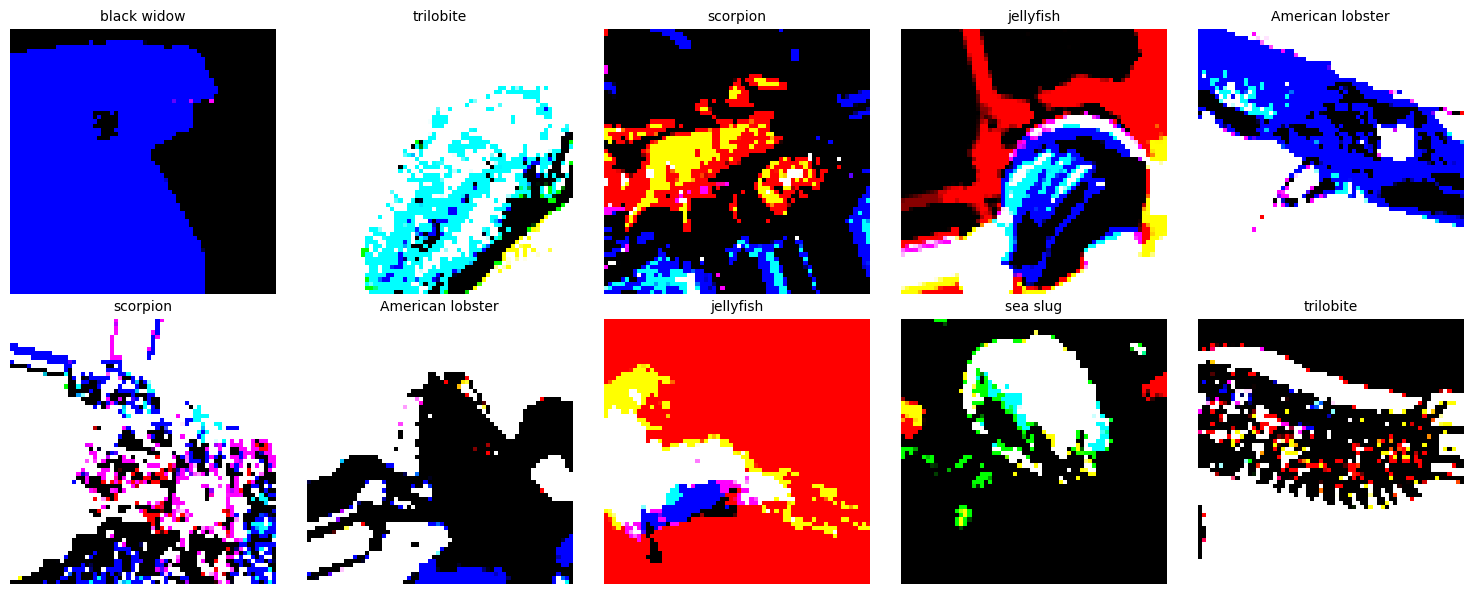

In [14]:
# Load wnid → human-readable class mapping (first name only)
wnid_to_label = {}
with open("/content/tiny-imagenet/tiny-imagenet-200/words.txt", "r") as f:
    for line in f:
        wnid, label = line.strip().split("\t")
        wnid_to_label[wnid] = label.split(',')[0]  # take only the first name

import matplotlib.pyplot as plt

# Map numeric label → wnid → human-readable name
numeric_to_wnid = {v: k for k, v in train_gen.class_indices.items()}

num_images = 10
indices = np.random.choice(x_train.shape[0], num_images, replace=False)
images = x_train[indices]
labels = y_train[indices]
label_indices = np.argmax(labels, axis=1)

# Undo preprocessing for visualization if using resnet_preprocess
images = images.copy()
images += 1.0
images *= 127.5
images = np.clip(images, 0, 255).astype('uint8')

plt.figure(figsize=(15, 6))
for i in range(num_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    wnid = numeric_to_wnid[label_indices[i]]
    plt.title(wnid_to_label.get(wnid, wnid), fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()


### Training function

In [ ]:
# ===================== Training Function =====================
def train_and_evaluate(model, model_name, x_train, y_train, x_val, y_val, x_test, y_test,
                    epochs=20, batch_size=64, learning_rate=0.001):
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    callbacks = [
        keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=3, min_lr=1e-6)
    ]
    start_time = time.time()
    history = model.fit(
        x_train.astype('float32'), y_train.astype('float32'),
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_val.astype('float32'), y_val.astype('float32')),
        callbacks=callbacks,
        verbose=1
    )
    training_time = time.time() - start_time
    test_loss, test_acc = model.evaluate(x_test.astype('float32'), y_test.astype('float32'), verbose=0)
    print(f"{model_name} - Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")
    print(f"{model_name} - Training Time: {training_time:.2f} seconds")
    return history, test_acc, test_loss, training_time


### Ploting Training Curves

In [ ]:

# ===================== Plot Training Curves =====================
def plot_training_history(history):
    # Accuracy plot
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

### VIT Model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time
import matplotlib.pyplot as plt
import numpy as np

# ===================== Patch Extraction Layer =====================
class Patches(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

# ===================== Patch Encoder Layer =====================
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

# ===================== MLP block =====================
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# ===================== Create ViT Model =====================
def create_vit_classifier(
    input_shape=(64, 64, 3),
    patch_size=4,
    num_patches=(64 // 4) ** 2,
    projection_dim=64,
    num_heads=4,
    transformer_layers=4,
    mlp_head_units=[128, 64],
    num_classes=20,
    positional_embedding_type="learned"
):
    inputs = layers.Input(shape=input_shape)
    x = layers.Rescaling(1.0/255)(inputs)
    patches = Patches(patch_size)(x)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Transformer blocks
    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=mlp_head_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.GlobalAveragePooling1D()(representation)
    representation = layers.Dropout(0.5)(representation)
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    outputs = layers.Dense(num_classes, activation="softmax")(features)

    model = keras.Model(inputs=inputs, outputs=outputs, name="ViT_Classifier")
    return model



Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 64s 219ms/step - accuracy: 0.0710 - loss: 3.0666 - val_accuracy: 0.1350 - val_loss: 2.8336 - learning_rate: 0.0010
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.1038 - loss: 2.9082 - val_accuracy: 0.1670 - val_loss: 2.7877 - learning_rate: 0.0010
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.1319 - loss: 2.8276 - val_accuracy: 0.1730 - val_loss: 2.6985 - learning_rate: 0.0010
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.1572 - loss: 2.7603 - val_accuracy: 0.1830 - val_loss: 2.6406 - learning_rate: 0.0010
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.1754 - loss: 2.6894 - val_accuracy: 0.2140 - val_loss: 2.6035 - learning_rate: 0.0010
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.1793 - loss: 2.6710 - val_accuracy: 0.1980 - val_loss: 2.5893 - learning_rate: 0.0010
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.1918 - loss

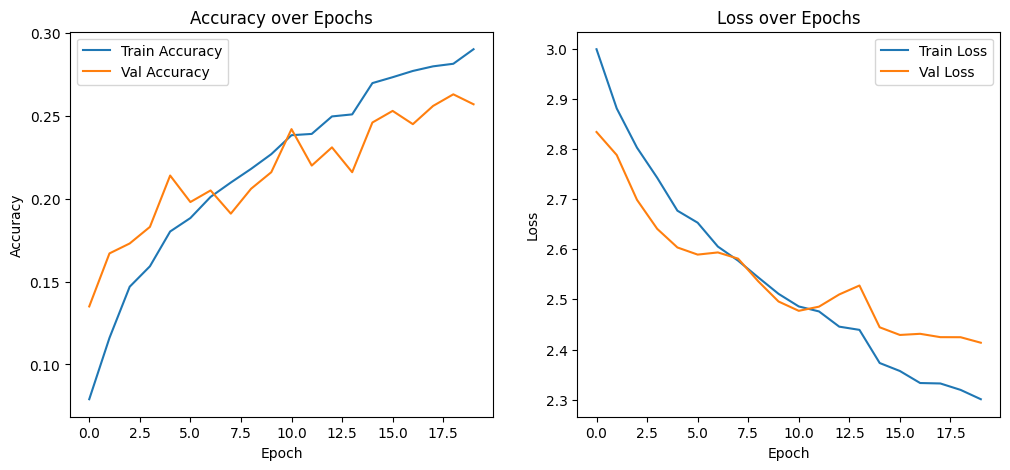

In [ ]:

# ===================== Example Usage =====================
vit_model = create_vit_classifier()
history_vit, test_acc_vit, test_loss_vit, training_time_vit = train_and_evaluate(
    vit_model, "ViT_Classifier",
    x_train, y_train,
    x_val, y_val,
    x_test, y_test,
    epochs=20,
    batch_size=64,
    learning_rate=0.001
)

# Plot training history
plot_training_history(history_vit)


### FCNN

In [ ]:
# ===================== Fully Connected Feed-Forward Network =====================
def create_fcfnn(input_shape=(64,64,3), hidden_units=[512, 256, 128], num_classes=20):
    inputs = keras.Input(shape=input_shape)
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Flatten()(x)
    for units in hidden_units:
        x = layers.Dense(units, activation='relu')(x)
        x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name="FCFNN")
    return model

Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.0851 - loss: 3.3478 - val_accuracy: 0.1330 - val_loss: 2.8357 - learning_rate: 0.0010
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1222 - loss: 2.8987 - val_accuracy: 0.1480 - val_loss: 2.8141 - learning_rate: 0.0010
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1374 - loss: 2.8229 - val_accuracy: 0.1550 - val_loss: 2.7756 - learning_rate: 0.0010
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1483 - loss: 2.7764 - val_accuracy: 0.1690 - val_loss: 2.7484 - learning_rate: 0.0010
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1557 - loss: 2.7528 - val_accuracy: 0.1750 - val_loss: 2.7186 - learning_rate: 0.0010
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1732 - loss: 2.7063 - val_accuracy: 0.1780 - val_loss: 2.6860 - learning_rate: 0.0010
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1793 - loss: 2.6766 -

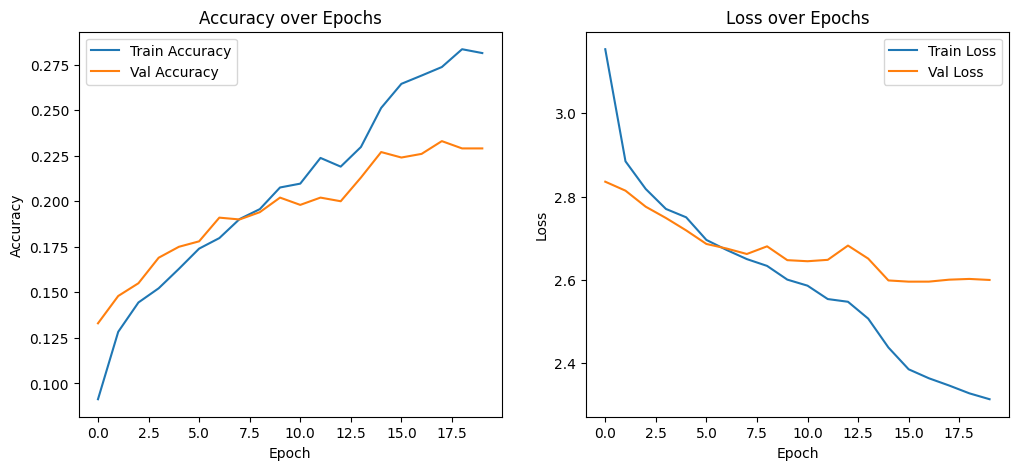

In [ ]:
# Create the FCFNN model
fcfnn_model = create_fcfnn(input_shape=(64, 64, 3), hidden_units=[512, 256, 128], num_classes=20)

# Train and evaluate
history_fcfnn, test_acc_fcfnn, test_loss_fcfnn, training_time_fcfnn = train_and_evaluate(
    fcfnn_model, "FCFNN_Classifier",
    x_train, y_train,
    x_val, y_val,
    x_test, y_test,
    epochs=20,
    batch_size=64,
    learning_rate=0.001
)

# Plot training history
plot_training_history(history_fcfnn)

### CNN

In [ ]:
# ===================== CNN-based Classifier =====================
def create_cnn(input_shape=(64,64,3), num_classes=20):
    inputs = keras.Input(shape=input_shape)
    x = layers.Rescaling(1./255)(inputs)

    # Conv block 1
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)

    # Conv block 2
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)

    # Conv block 3
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name="CNN_Classifier")
    return model

Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - accuracy: 0.1138 - loss: 2.8643 - val_accuracy: 0.2020 - val_loss: 2.6048 - learning_rate: 0.0010
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.1962 - loss: 2.5913 - val_accuracy: 0.2510 - val_loss: 2.4241 - learning_rate: 0.0010
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2580 - loss: 2.4278 - val_accuracy: 0.2750 - val_loss: 2.3472 - learning_rate: 0.0010
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2926 - loss: 2.3459 - val_accuracy: 0.3190 - val_loss: 2.2724 - learning_rate: 0.0010
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3306 - loss: 2.2261 - val_accuracy: 0.3430 - val_loss: 2.1903 - learning_rate: 0.0010
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3467 - loss: 2.1292 - val_accuracy: 0.3650 - val_loss: 2.1331 - learning_rate: 0.0010
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3833 - loss: 

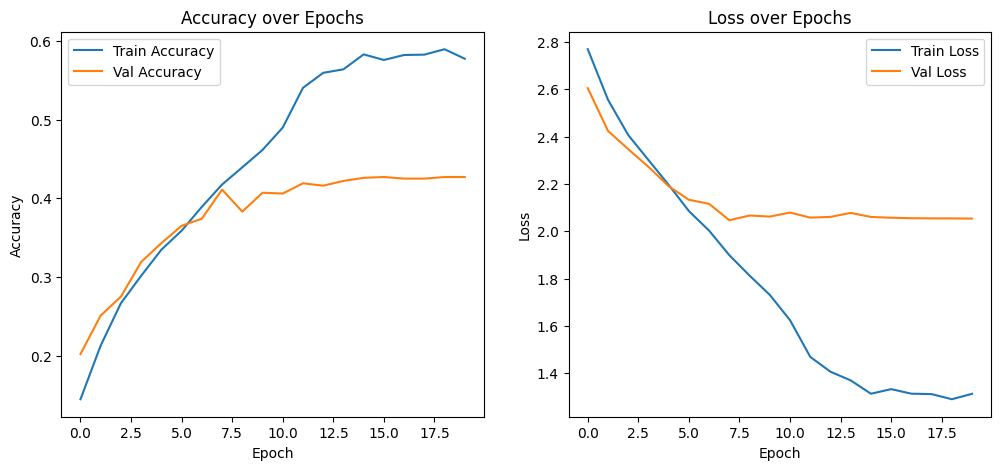

In [ ]:
# Create the CNN model
cnn_model = create_cnn(input_shape=(64, 64, 3), num_classes=20)

# Train and evaluate
history_cnn, test_acc_cnn, test_loss_cnn, training_time_cnn = train_and_evaluate(
    cnn_model, "CNN_Classifier",
    x_train, y_train,
    x_val, y_val,
    x_test, y_test,
    epochs=20,
    batch_size=64,
    learning_rate=0.001
)

# Plot training history
plot_training_history(history_cnn)

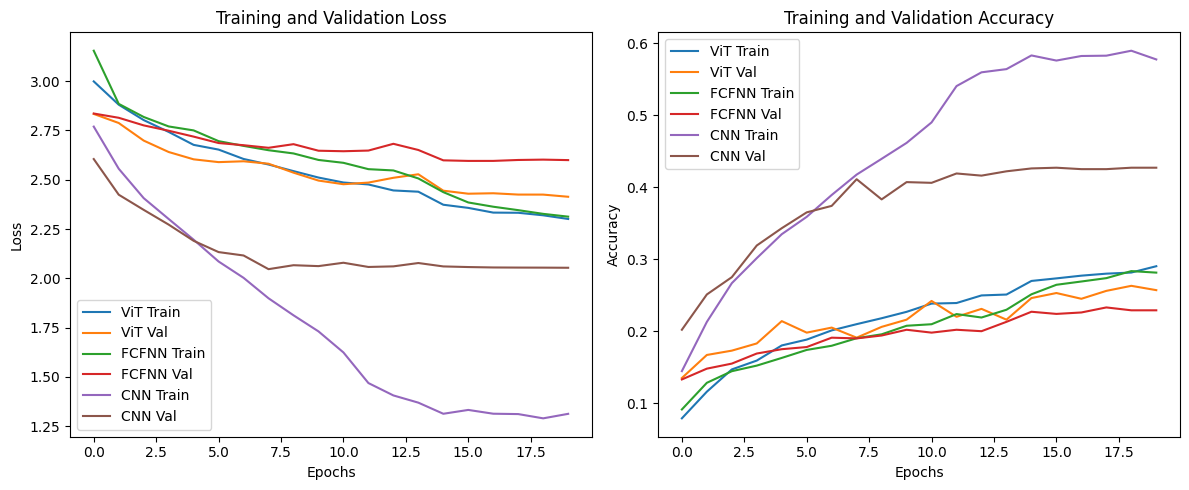

ViT - Test Accuracy: 0.2490, Test Loss: 2.3839, Training Time: 248.73 sec
FCFNN - Test Accuracy: 0.2200, Test Loss: 2.5445, Training Time: 31.65 sec
CNN - Test Accuracy: 0.3970, Test Loss: 2.0284, Training Time: 62.67 sec


In [ ]:
# ===================== Plot Comparison of Loss =====================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_vit.history['loss'], label='ViT Train')
plt.plot(history_vit.history['val_loss'], label='ViT Val')
plt.plot(history_fcfnn.history['loss'], label='FCFNN Train')
plt.plot(history_fcfnn.history['val_loss'], label='FCFNN Val')
plt.plot(history_cnn.history['loss'], label='CNN Train')
plt.plot(history_cnn.history['val_loss'], label='CNN Val')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# ===================== Plot Comparison of Accuracy =====================
plt.subplot(1,2,2)
plt.plot(history_vit.history['accuracy'], label='ViT Train')
plt.plot(history_vit.history['val_accuracy'], label='ViT Val')
plt.plot(history_fcfnn.history['accuracy'], label='FCFNN Train')
plt.plot(history_fcfnn.history['val_accuracy'], label='FCFNN Val')
plt.plot(history_cnn.history['accuracy'], label='CNN Train')
plt.plot(history_cnn.history['val_accuracy'], label='CNN Val')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# ===================== Print Test Accuracy, Loss, and Training Time =====================
print(f"ViT - Test Accuracy: {test_acc_vit:.4f}, Test Loss: {test_loss_vit:.4f}, Training Time: {training_time_vit:.2f} sec")
print(f"FCFNN - Test Accuracy: {test_acc_fcfnn:.4f}, Test Loss: {test_loss_fcfnn:.4f}, Training Time: {training_time_fcfnn:.2f} sec")
print(f"CNN - Test Accuracy: {test_acc_cnn:.4f}, Test Loss: {test_loss_cnn:.4f}, Training Time: {training_time_cnn:.2f} sec")


### Effect of number of Heads


Training ViT with 1 attention heads...
Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 55s 185ms/step - accuracy: 0.0614 - loss: 3.0699 - val_accuracy: 0.1530 - val_loss: 2.8337 - learning_rate: 0.0010
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.1027 - loss: 2.8988 - val_accuracy: 0.1530 - val_loss: 2.7675 - learning_rate: 0.0010
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.1322 - loss: 2.8163 - val_accuracy: 0.1850 - val_loss: 2.6613 - learning_rate: 0.0010
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.1706 - loss: 2.7261 - val_accuracy: 0.2130 - val_loss: 2.5932 - learning_rate: 0.0010
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.1778 - loss: 2.6703 - val_accuracy: 0.2090 - val_loss: 2.5831 - learning_rate: 0.0010
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.1950 - loss: 2.6284 - val_accuracy: 0.2270 - val_loss: 2.5195 - learning_rate: 0.0010
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 

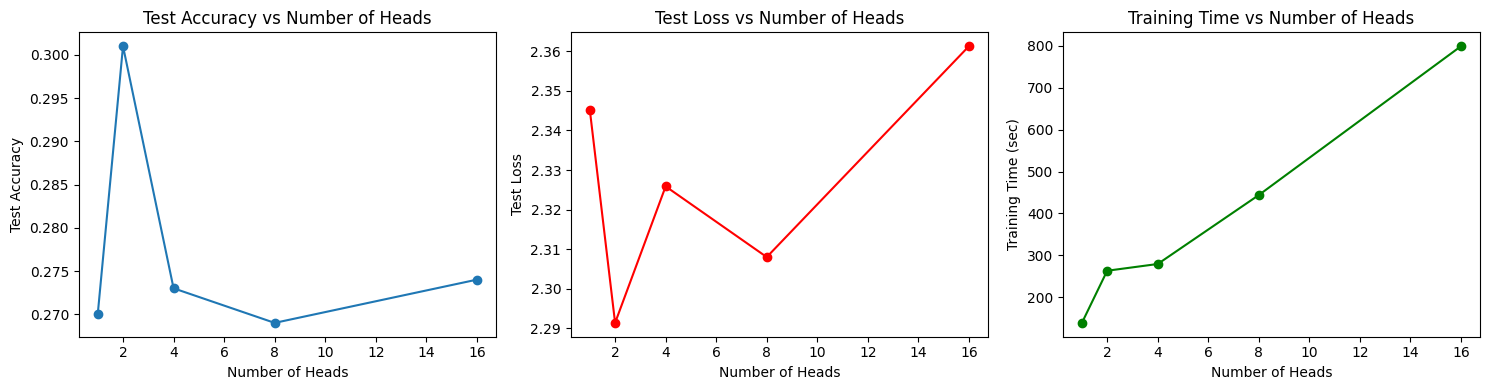

In [ ]:
import matplotlib.pyplot as plt

# Define the number of heads 
head_options = [1, 2, 4, 8, 16]
results = []

for heads in head_options:
    print(f"\nTraining ViT with {heads} attention heads...")
    vit_model = create_vit_classifier(
        input_shape=(64, 64, 3),
        patch_size=4,
        projection_dim=64,
        num_heads=heads,
        transformer_layers=4,
        mlp_head_units=[128, 64],
        num_classes=20
    )

    history, test_acc, test_loss, training_time = train_and_evaluate(
        vit_model, f"ViT_{heads}_heads",
        x_train, y_train,
        x_val, y_val,
        x_test, y_test,
        epochs=20,
        batch_size=64,
        learning_rate=0.001
    )

    # Save results
    results.append({
        "heads": heads,
        "history": history,
        "test_acc": test_acc,
        "test_loss": test_loss,
        "training_time": training_time
    })

# ===================== Plot Accuracy and Loss vs Number of Heads =====================
accs = [r['test_acc'] for r in results]
losses = [r['test_loss'] for r in results]
times = [r['training_time'] for r in results]

plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.plot(head_options, accs, marker='o')
plt.title('Test Accuracy vs Number of Heads')
plt.xlabel('Number of Heads')
plt.ylabel('Test Accuracy')

plt.subplot(1,3,2)
plt.plot(head_options, losses, marker='o', color='red')
plt.title('Test Loss vs Number of Heads')
plt.xlabel('Number of Heads')
plt.ylabel('Test Loss')

plt.subplot(1,3,3)
plt.plot(head_options, times, marker='o', color='green')
plt.title('Training Time vs Number of Heads')
plt.xlabel('Number of Heads')
plt.ylabel('Training Time (sec)')

plt.tight_layout()
plt.show()


### Effect of Patch Sizes


Training ViT with patch size 2x2...
Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 154s 845ms/step - accuracy: 0.0634 - loss: 3.1401 - val_accuracy: 0.1200 - val_loss: 2.8975 - learning_rate: 0.0010
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 95s 657ms/step - accuracy: 0.0933 - loss: 2.9389 - val_accuracy: 0.1370 - val_loss: 2.8126 - learning_rate: 0.0010
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 140s 643ms/step - accuracy: 0.1193 - loss: 2.8755 - val_accuracy: 0.1790 - val_loss: 2.7050 - learning_rate: 0.0010
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 144s 659ms/step - accuracy: 0.1443 - loss: 2.7884 - val_accuracy: 0.1830 - val_loss: 2.6726 - learning_rate: 0.0010
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 90s 641ms/step - accuracy: 0.1709 - loss: 2.6858 - val_accuracy: 0.1860 - val_loss: 2.6260 - learning_rate: 0.0010
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 93s 657ms/step - accuracy: 0.1879 - loss: 2.6384 - val_accuracy: 0.1640 - val_loss: 2.6163 - learning_rate: 0.0010
Epoch 7/20
141/141 ━━━━━━━━━━━

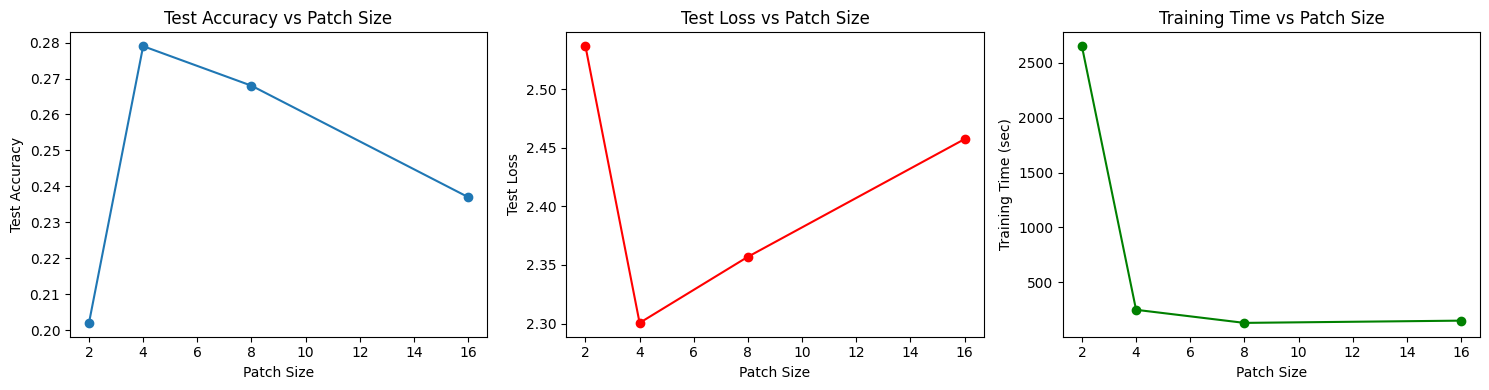

In [ ]:
import matplotlib.pyplot as plt

# Define different patch sizes to experiment with
patch_sizes = [2, 4, 8, 16]
results_patch = []

for patch in patch_sizes:
    print(f"\nTraining ViT with patch size {patch}x{patch}...")

    # Compute number of patches based on input image size 64x64
    num_patches = (64 // patch) ** 2

    vit_model = create_vit_classifier(
        input_shape=(64, 64, 3),
        patch_size=patch,
        num_patches=num_patches,
        projection_dim=64,
        num_heads=4,
        transformer_layers=4,
        mlp_head_units=[128, 64],
        num_classes=20
    )

    history, test_acc, test_loss, training_time = train_and_evaluate(
        vit_model, f"ViT_patch_{patch}",
        x_train, y_train,
        x_val, y_val,
        x_test, y_test,
        epochs=20,
        batch_size=64,
        learning_rate=0.001
    )

    results_patch.append({
        "patch_size": patch,
        "history": history,
        "test_acc": test_acc,
        "test_loss": test_loss,
        "training_time": training_time
    })

# ===================== Plot Test Accuracy, Loss, and Training Time =====================
accs = [r['test_acc'] for r in results_patch]
losses = [r['test_loss'] for r in results_patch]
times = [r['training_time'] for r in results_patch]

plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.plot(patch_sizes, accs, marker='o')
plt.title('Test Accuracy vs Patch Size')
plt.xlabel('Patch Size')
plt.ylabel('Test Accuracy')

plt.subplot(1,3,2)
plt.plot(patch_sizes, losses, marker='o', color='red')
plt.title('Test Loss vs Patch Size')
plt.xlabel('Patch Size')
plt.ylabel('Test Loss')

plt.subplot(1,3,3)
plt.plot(patch_sizes, times, marker='o', color='green')
plt.title('Training Time vs Patch Size')
plt.xlabel('Patch Size')
plt.ylabel('Training Time (sec)')

plt.tight_layout()
plt.show()


### Effect of Positiona Embedding


Training ViT with learned positional embedding...
Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 65s 227ms/step - accuracy: 0.0710 - loss: 3.0666 - val_accuracy: 0.1350 - val_loss: 2.8336 - learning_rate: 0.0010
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 39s 65ms/step - accuracy: 0.1044 - loss: 2.9114 - val_accuracy: 0.1580 - val_loss: 2.7813 - learning_rate: 0.0010
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.1354 - loss: 2.8223 - val_accuracy: 0.1720 - val_loss: 2.6827 - learning_rate: 0.0010
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.1536 - loss: 2.7649 - val_accuracy: 0.1910 - val_loss: 2.6640 - learning_rate: 0.0010
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.1619 - loss: 2.7075 - val_accuracy: 0.1910 - val_loss: 2.5980 - learning_rate: 0.0010
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.1804 - loss: 2.6656 - val_accuracy: 0.1960 - val_loss: 2.5828 - learning_rate: 0.0010
Epoch 7/20
141/141 ━━━━━━━━

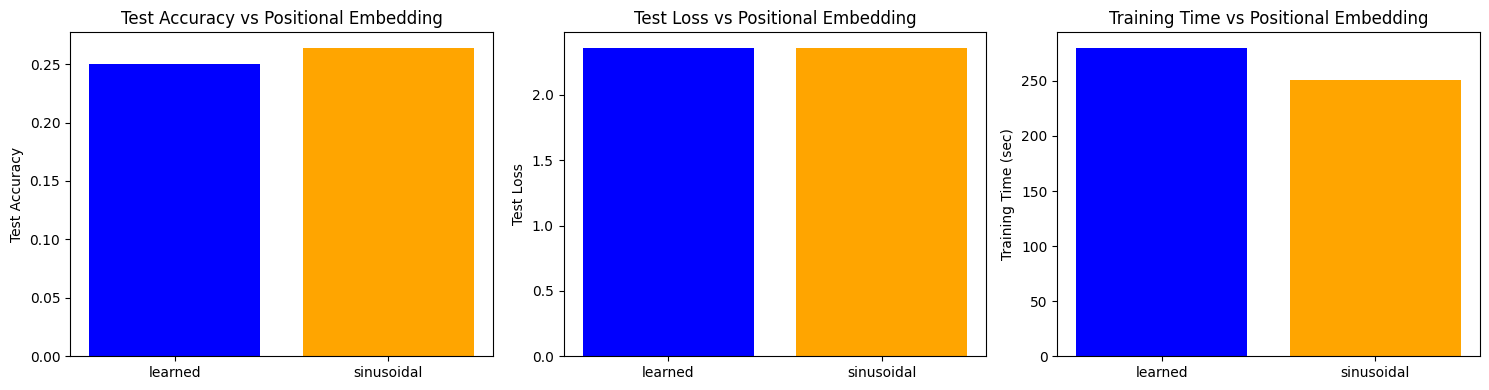

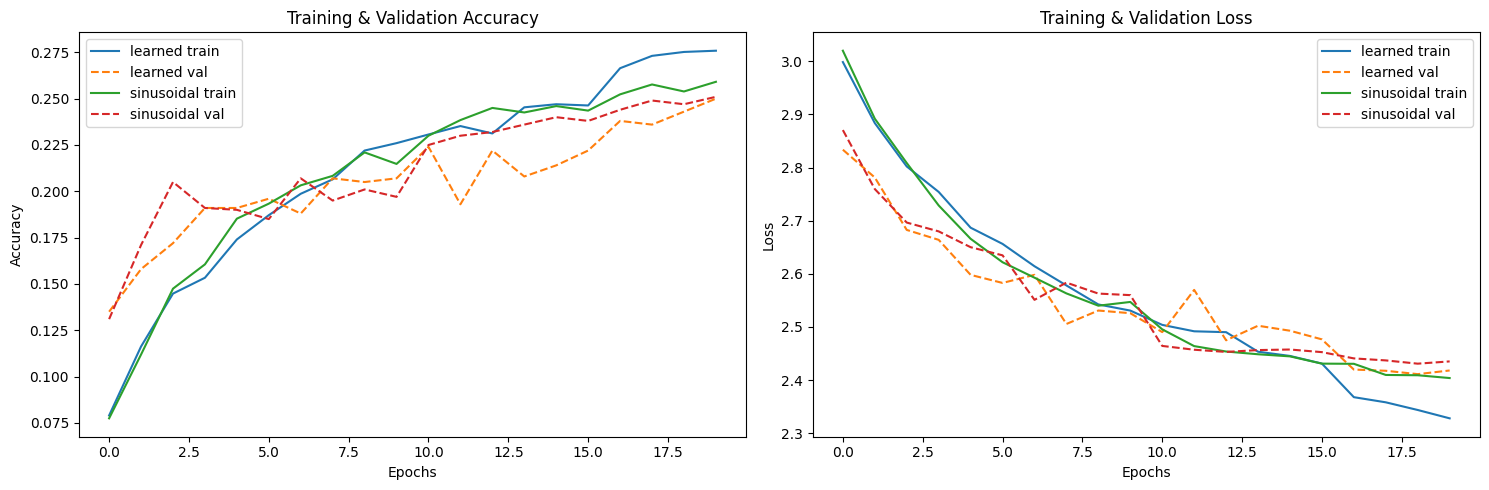

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, positional_embedding_type="learned", **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.positional_embedding_type = positional_embedding_type

        if positional_embedding_type == "learned":
            self.position_embedding = layers.Embedding(
                input_dim=num_patches, output_dim=projection_dim
            )
        elif positional_embedding_type == "sinusoidal":
            # Precompute sinusoidal embeddings
            self.position_embedding = self.get_sinusoidal_embeddings(num_patches, projection_dim)

    def get_sinusoidal_embeddings(self, num_patches, projection_dim):
        import numpy as np
        positions = np.arange(num_patches)[:, np.newaxis]
        dims = np.arange(projection_dim)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (dims//2)) / np.float32(projection_dim))
        angle_rads = positions * angle_rates
        # apply sin to even indices, cos to odd indices
        sines = np.sin(angle_rads[:, 0::2])
        cosines = np.cos(angle_rads[:, 1::2])
        embeddings = np.zeros((num_patches, projection_dim))
        embeddings[:, 0::2] = sines
        embeddings[:, 1::2] = cosines
        return tf.constant(embeddings, dtype=tf.float32)

    def call(self, patch):
        if self.positional_embedding_type == "learned":
            positions = tf.range(start=0, limit=self.num_patches, delta=1)
            encoded = self.projection(patch) + self.position_embedding(positions)
        elif self.positional_embedding_type == "sinusoidal":
            encoded = self.projection(patch) + self.position_embedding
        return encoded


# ===================== Compare Learned vs Sinusoidal =====================
positional_types = ["learned", "sinusoidal"]
results_pos = []

for p_type in positional_types:
    print(f"\nTraining ViT with {p_type} positional embedding...")

    vit_model = create_vit_classifier(
        input_shape=(64,64,3),
        patch_size=4,
        num_patches=(64//4)**2,
        projection_dim=64,
        num_heads=4,
        transformer_layers=4,
        mlp_head_units=[128,64],
        num_classes=20,
        positional_embedding_type=p_type
    )

    history, test_acc, test_loss, training_time = train_and_evaluate(
        vit_model, f"ViT_{p_type}_pos",
        x_train, y_train,
        x_val, y_val,
        x_test, y_test,
        epochs=20,
        batch_size=64,
        learning_rate=0.001
    )

    results_pos.append({
        "type": p_type,
        "history": history,
        "test_acc": test_acc,
        "test_loss": test_loss,
        "training_time": training_time
    })

# ===================== Plot Comparison =====================
accs = [r['test_acc'] for r in results_pos]
losses = [r['test_loss'] for r in results_pos]
times = [r['training_time'] for r in results_pos]

plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.bar(positional_types, accs, color=['blue','orange'])
plt.title('Test Accuracy vs Positional Embedding')
plt.ylabel('Test Accuracy')

plt.subplot(1,3,2)
plt.bar(positional_types, losses, color=['blue','orange'])
plt.title('Test Loss vs Positional Embedding')
plt.ylabel('Test Loss')

plt.subplot(1,3,3)
plt.bar(positional_types, times, color=['blue','orange'])
plt.title('Training Time vs Positional Embedding')
plt.ylabel('Training Time (sec)')

plt.tight_layout()
plt.show()

# ===================== Plot Training Curves =====================
plt.figure(figsize=(15,5))

for r in results_pos:
    history = r['history']
    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label=f"{r['type']} train")
    plt.plot(history.history['val_accuracy'], '--', label=f"{r['type']} val")
    plt.title("Training & Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label=f"{r['type']} train")
    plt.plot(history.history['val_loss'], '--', label=f"{r['type']} val")
    plt.title("Training & Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

plt.tight_layout()
plt.show()
